In [1]:
!pip install loguru

import sys
from google.colab import drive
drive.mount('/content/drive')

# set path
base_dir = '/content/drive/My Drive/Risk Forecasting'
sys.path.append(base_dir)

import os
import numpy as np
import pandas as pd
import torch
import gc
import matplotlib.pyplot as plt
import contextlib
from torch.cuda.amp import GradScaler
from loguru import logger
from models import SVM, TFT_GRU, LGBM, Naive
from utils import ForecastStats, reconstruct_levels, rolling_test, plot_predictions_vs_actuals, plot_residuals, plot_residuals_violin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.9 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Test and Eval notebook

EECS MSc Project - Research Based - 2024 <br/><br/>
An Incremental Batch Learning Performance Assessment of CDS Implied Volatility n-step Estimation Approaches <br/><br/> Robert Taylor, Queen Mary, UoL

In [2]:
logger.remove()
logger.add("log.txt", level="CRITICAL")
logger.add(sys.stderr, level="INFO")

plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('mathtext', fontset='stix')

# mixed precision
scaler = GradScaler()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

feature_matrix_path, target_vector_path = os.path.join(base_dir, 'features.pkl'), os.path.join(base_dir, 'RESPONSE Main 1m.xls')

feature_matrix = pd.read_pickle(feature_matrix_path)
target_vector = (pd.read_excel(target_vector_path, skiprows=range(6)).rename(columns=lambda x: x.strip()).assign(**{'Effective date': lambda df: pd
                .to_datetime(df['Effective date'], errors='coerce')}).dropna(subset=['Effective date']).set_index('Effective date'))

feature_matrix.index = pd.to_datetime(feature_matrix.index, errors='coerce')
target_vector.index = pd.to_datetime(target_vector.index, errors='coerce')

# take ln for stationarity
ln_target_vector = np.log(target_vector).diff().dropna()

# set sample range and take intersection
train_index = feature_matrix.index.intersection(ln_target_vector.index)

X = feature_matrix.loc[train_index]
y = ln_target_vector.loc[train_index]

Using device: cuda


In [3]:
X = X.iloc[:, :5] # feature set

print(f"X shape: {X.shape}")

X shape: (156, 5)


### test loop

In [4]:
predictions = 63  # subset at end of sliced observations dedicated to estimates (model will be fit on observations - predictions)
sequence_length = 5  # length of sequences (set to 5 for trading week)
window = 63
log_path = os.path.join(base_dir, 'full_log.txt')

In [5]:
with open(log_path, 'w') as f:
    with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
        raw_metrics = {}
        levels_metrics = {}
        model_name_suffix = f' w {window}-period'

        # models
        models = [
            ('Naïve Forecast', Naive),
            (f'TFT-GRU{model_name_suffix}', TFT_GRU),
            (f'SVM{model_name_suffix}', SVM),
            (f'LightGBM{model_name_suffix}', LGBM)
        ]

        for model_name, model_class in models:
            with contextlib.redirect_stdout(sys.__stdout__):
                print(f'Testing {model_name}')

            # train & test
            raw_metrics[model_name] = rolling_test(
                model_class, X, y, chunk=(window + predictions), predictions=predictions, sequence_length=sequence_length, model_name=model_name
            )

            levels_metrics[model_name] = reconstruct_levels(
                target_vector, raw_metrics[model_name]
            )

            # gc
            del model_name
            gc.collect()

logger.info("Metrics recorded.")

2024-08-11 21:01:16.479 | INFO     | utils:rolling_test:76 - Starting Naïve Forecast test
2024-08-11 21:01:16.481 | INFO     | utils:rolling_test:102 - Test 1/63
2024-08-11 21:01:16.731 | INFO     | utils:rolling_test:102 - Test 2/63
2024-08-11 21:01:16.985 | INFO     | utils:rolling_test:102 - Test 3/63
2024-08-11 21:01:17.230 | INFO     | utils:rolling_test:102 - Test 4/63
2024-08-11 21:01:17.474 | INFO     | utils:rolling_test:102 - Test 5/63
2024-08-11 21:01:17.718 | INFO     | utils:rolling_test:102 - Test 6/63
2024-08-11 21:01:17.960 | INFO     | utils:rolling_test:102 - Test 7/63
2024-08-11 21:01:18.215 | INFO     | utils:rolling_test:102 - Test 8/63
2024-08-11 21:01:18.457 | INFO     | utils:rolling_test:102 - Test 9/63
2024-08-11 21:01:18.709 | INFO     | utils:rolling_test:102 - Test 10/63
2024-08-11 21:01:18.949 | INFO     | utils:rolling_test:102 - Test 11/63
2024-08-11 21:01:19.189 | INFO     | utils:rolling_test:102 - Test 12/63
2024-08-11 21:01:19.431 | INFO     | utils:

### eval

In [6]:
# metrics, log returns
forecast_stats = ForecastStats(raw_metrics, X)
result_table = forecast_stats.calculate_forecast_stats()

result_table_path = os.path.join(base_dir, 'metrics_table.tex')
with open(result_table_path, 'w') as f:
    f.write(result_table.to_latex(index=False))

result_table

,Model,MAE,RMSE,Diebold-Mariano,Giacomini-White
0,Naïve Forecast,0.051886,0.068031,NaN,NaN
1,TFT-GRU w 63-period,0.041333,0.050510,-0.00 (0.999),-0.38 (0.702)
2,SVM w 63-period,0.041683,0.052323,-0.45 (0.653),-0.22 (0.829)
3,LightGBM w 63-period,0.044387,0.054517,-0.70 (0.482),-0.11 (0.914)


In [7]:
# metrics, levels
level_metrics_table = forecast_stats.calculate_level_metrics(levels_metrics)

level_metrics_table_path = os.path.join(base_dir, 'level_metrics_table.tex')
with open(level_metrics_table_path, 'w') as f:
    f.write(level_metrics_table.to_latex(index=False))

level_metrics_table

/content/drive/My Drive/Risk Forecasting/utils.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table_levels = pd.concat([table_levels, pd.DataFrame(rows)], ignore_index=True)


,Model,MAPE,Log Loss
0,Naïve Forecast,5.214595,0.004628
1,TFT-GRU w 63-period,4.125548,0.002551
2,SVM w 63-period,4.186411,0.002738
3,LightGBM w 63-period,4.467672,0.002972


### plots

In [8]:
models = ['TFT-GRU', 'SVM', 'LightGBM']

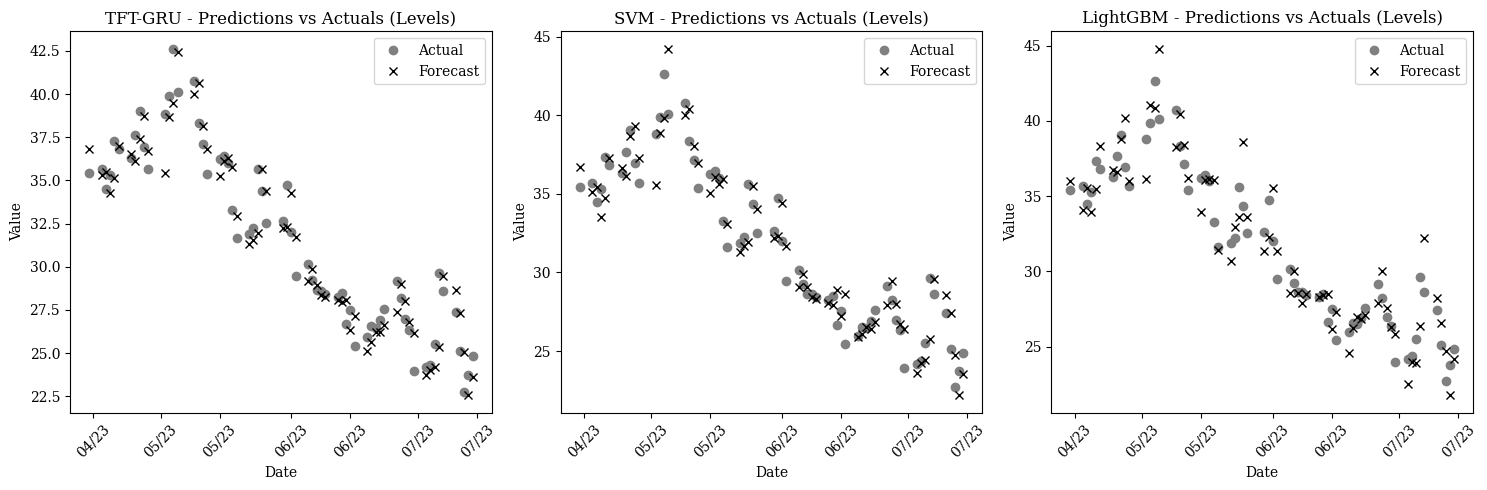

In [9]:
plot_predictions_vs_actuals(levels_metrics, models, model_name_suffix, window)

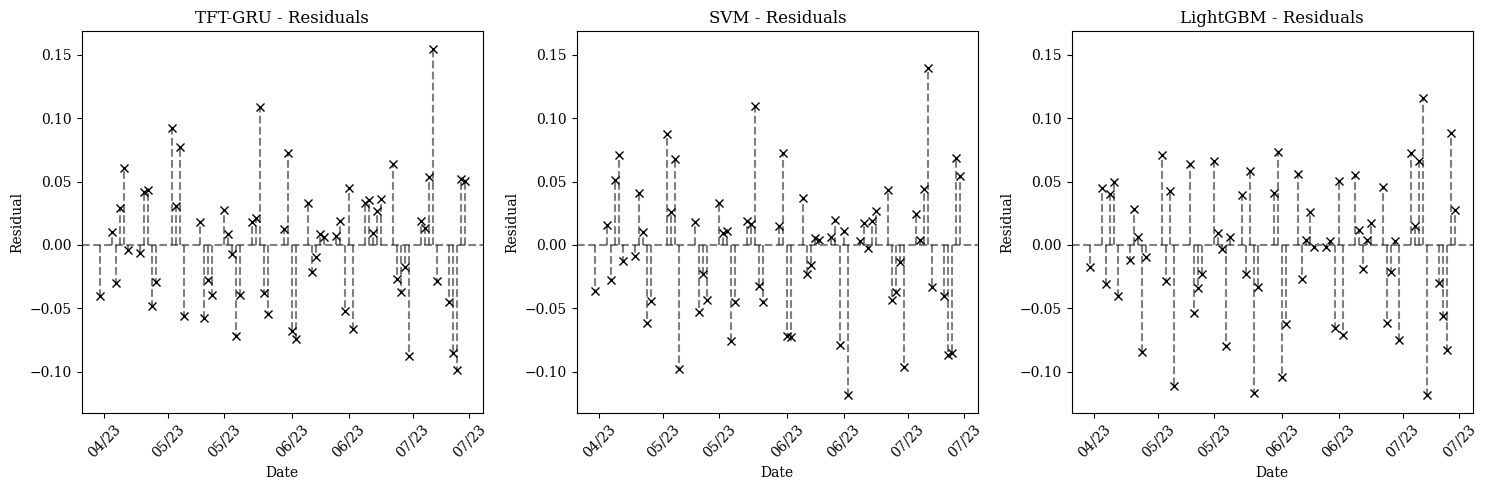

In [10]:
plot_residuals(raw_metrics, models, model_name_suffix, window)

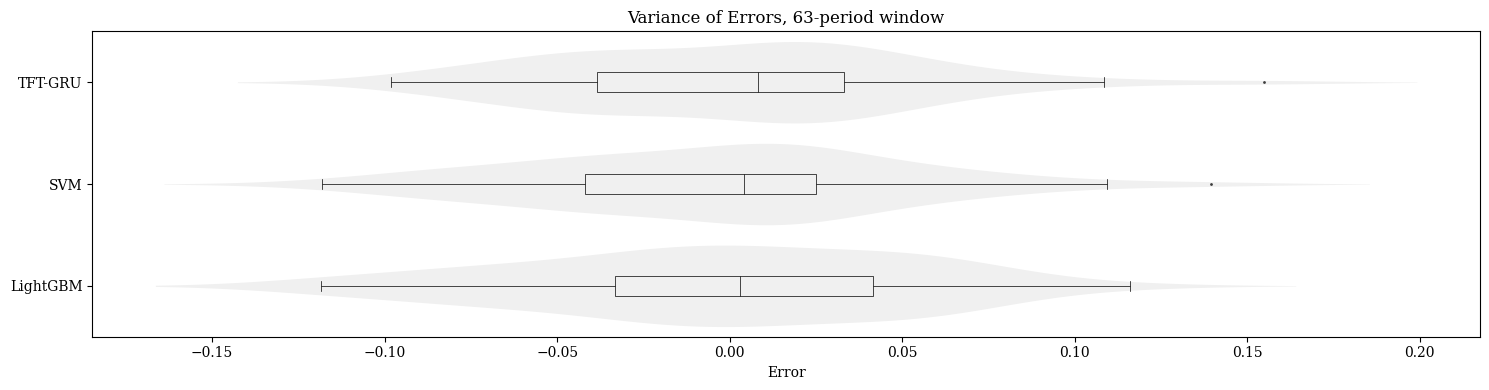

In [11]:
all_residuals = []
for model in models:
    suffix = f'{model}{model_name_suffix}'
    residuals = np.array(raw_metrics[suffix]['actuals']) - np.array(raw_metrics[suffix]['forecasts'])
    all_residuals.append(residuals)

plot_residuals_violin(all_residuals, models, window)